In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 792ms/step - loss: 0.0419
Average validation loss: 0.6582561135292053
4/4 [==============================] - 8s 806ms/step - loss: 0.0419 - val_loss: 0.6583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 782ms/step - loss: 0.0319 - val_loss: 0.6583
Average validation loss: 0.615874171257019
4/4 [==============================] - 12s 797ms/step - loss: 0.0319 - val_loss: 0.6371
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 770ms/step - loss: 0.0247 - val_loss: 0.6371
Average validation loss: 0.5726036429405212
4/4 [==============================] - 15s 784ms/step - loss: 0.0247 - val_los

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 792ms/step - loss: 0.0013
Average validation loss: 8.152532700478332e-06
8/8 [==============================] - 6s 807ms/step - loss: 0.0013 - val_loss: 8.1525e-06
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 784ms/step - loss: 0.0013 - val_loss: 8.1525e-06
Average validation loss: 0.00019442242046352476
8/8 [==============================] - 13s 795ms/step - loss: 0.0013 - val_loss: 1.0129e-04
Epoch 3/10
8/8 [==============================] - 19s 777ms/step - loss: 0.0013 - val_loss: 1.0129e-04
Average validation loss: 0.00027007918106392026
8/8 [==============================] - 19s 788ms/step - loss: 0.0013 - val_loss: 1.5755e-04
Epoch 4/10
8/8 [==============================] - 26s 802ms/step - loss: 0.0013 - val_loss: 1.5755e-04
Average validation loss: 0.00

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 742ms/step - loss: 0.0017
Average validation loss: 0.07318604737520218
12/12 [==============================] - 9s 755ms/step - loss: 0.0017 - val_loss: 0.0732
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 702ms/step - loss: 0.0018 - val_loss: 0.0732
Average validation loss: 0.04117557957943063
12/12 [==============================] - 18s 713ms/step - loss: 0.0018 - val_loss: 0.0572
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 715ms/step - loss: 0.0018 - val_loss: 0.0572
Average validation loss: 0.030480723556441564
12/12 [==============================] - 26s 727ms/step - los

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 731ms/step - loss: 0.0015
Average validation loss: 0.13314498774707317
16/16 [==============================] - 12s 743ms/step - loss: 0.0015 - val_loss: 0.1331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 716ms/step - loss: 0.0015 - val_loss: 0.1331
Average validation loss: 0.051728841150179505
16/16 [==============================] - 24s 727ms/step - loss: 0.0015 - val_loss: 0.0924
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 706ms/step - loss: 0.0015 - val_loss: 0.0924
Average validation loss: 0.027903037233045325
16/16 [==============================] - 35s 718ms/step - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 713ms/step - loss: 8.1612e-04
Average validation loss: 0.22406795732676982
20/20 [==============================] - 15s 727ms/step - loss: 8.1612e-04 - val_loss: 0.2241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 716ms/step - loss: 8.2007e-04 - val_loss: 0.2241
Average validation loss: 0.15433020405471326
20/20 [==============================] - 29s 729ms/step - loss: 8.2007e-04 - val_loss: 0.1892
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 709ms/step - loss: 8.1068e-04 - val_loss: 0.1892
Average validation loss: 0.14027591985650362
20/20 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 712ms/step - loss: 8.6710e-04
Average validation loss: 0.561587264140447
24/24 [==============================] - 17s 723ms/step - loss: 8.6710e-04 - val_loss: 0.5616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 709ms/step - loss: 7.7747e-04 - val_loss: 0.5616
Average validation loss: 0.4311700214942296
24/24 [==============================] - 35s 720ms/step - loss: 7.7747e-04 - val_loss: 0.4964
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 708ms/step - loss: 7.4212e-04 - val_loss: 0.4964
Average validation loss: 0.31500022610028583
24/24 [==============================] - 52

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 714ms/step - loss: 0.0010
Average validation loss: 0.21926383078098297
40/40 [==============================] - 29s 726ms/step - loss: 0.0010 - val_loss: 0.2193
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 712ms/step - loss: 9.8901e-04 - val_loss: 0.2193
Average validation loss: 0.1467539742588997
40/40 [==============================] - 58s 724ms/step - loss: 9.8901e-04 - val_loss: 0.1830
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 711ms/step - loss: 9.3795e-04 - val_loss: 0.1830
Average validation loss: 0.0654070433229208
40/40 [==============================] - 87s 724ms

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 710ms/step - loss: 8.3559e-04
Average validation loss: 0.1695794872375321
48/48 [==============================] - 35s 721ms/step - loss: 8.3559e-04 - val_loss: 0.1696
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 723ms/step - loss: 7.7196e-04 - val_loss: 0.1696
Average validation loss: 0.17551313433644586
48/48 [==============================] - 70s 735ms/step - loss: 7.7196e-04 - val_loss: 0.1725
Epoch 3/10
48/48 [==============================] - 105s 720ms/step - loss: 7.2589e-04 - val_loss: 0.1725
Average validation loss: 0.06400524307310225
48/48 [==============================] - 105s 732ms/step - loss: 7.2589e-04 - val_loss: 0.1364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 711ms/step - loss: 8.6380e-04
Average validation loss: 0.10218936155485737
56/56 [==============================] - 40s 723ms/step - loss: 8.6380e-04 - val_loss: 0.1022
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 712ms/step - loss: 7.3147e-04 - val_loss: 0.1022
Average validation loss: 0.15648978122369175
56/56 [==============================] - 81s 723ms/step - loss: 7.3147e-04 - val_loss: 0.1293
Epoch 3/10
56/56 [==============================] - 122s 726ms/step - loss: 6.7447e-04 - val_loss: 0.1293
Average validation loss: 0.11826372176957582
56/56 [==============================] - 122s 738ms/step - loss: 6.7447e-04 - val_loss: 0.1256
Epoch 4/10
56/56 [==============================] - 162s 709ms/step - loss: 6.1751e-04 - val_loss: 0.1256
Average valida

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 711ms/step - loss: 6.2090e-04
Average validation loss: 0.391999584176034
64/64 [==============================] - 46s 722ms/step - loss: 6.2090e-04 - val_loss: 0.3920
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 716ms/step - loss: 5.4949e-04 - val_loss: 0.3920
Average validation loss: 0.10606771986061853
64/64 [==============================] - 93s 728ms/step - loss: 5.4949e-04 - val_loss: 0.2490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 139s 716ms/step - loss: 4.8132e-04 - val_loss: 0.2490
Average validation loss: 0.1258482128467726
64/64 [==============================] - 1

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 723ms/step - loss: 5.8145e-04
Average validation loss: 0.07121177390217781
72/72 [==============================] - 53s 734ms/step - loss: 5.8145e-04 - val_loss: 0.0712
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 718ms/step - loss: 4.9562e-04 - val_loss: 0.0712
Average validation loss: 0.10881155894862281
72/72 [==============================] - 106s 730ms/step - loss: 4.9562e-04 - val_loss: 0.0900
Epoch 3/10
72/72 [==============================] - 157s 713ms/step - loss: 4.7231e-04 - val_loss: 0.0900
Average validation loss: 0.11920323512620395
72/72 [==============================] - 158s 725ms/step - loss: 4.7231e-04 - val_loss: 0.0997
Epoch 4/10
72/72 [==============================] - 210s 718ms/step - loss: 4.5270e-04 - val_loss: 0.0997
Average vali

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 719ms/step - loss: 5.7240e-04
Average validation loss: 0.07413013949990273
80/80 [==============================] - 59s 731ms/step - loss: 5.7240e-04 - val_loss: 0.0741
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 714ms/step - loss: 4.7530e-04 - val_loss: 0.0741
Average validation loss: 0.14105722904205323
80/80 [==============================] - 117s 726ms/step - loss: 4.7530e-04 - val_loss: 0.1076
Epoch 3/10
80/80 [==============================] - 173s 709ms/step - loss: 4.2217e-04 - val_loss: 0.1076
Average validation loss: 0.08385639749467373
80/80 [==============================] - 174s 721ms/step - loss: 4.2217e-04 - val_loss: 0.0997
Epoch 4/10
80/80 [==============================] - 231s 714ms/step - loss: 4.0156e-04 - val_loss: 0.0997
Average val

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 716ms/step - loss: 7.9304e-04
Average validation loss: 0.2973106913268566
96/96 [==============================] - 70s 728ms/step - loss: 7.9304e-04 - val_loss: 0.2973
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 713ms/step - loss: 6.5179e-04 - val_loss: 0.2973
Average validation loss: 0.13766394710789123
96/96 [==============================] - 139s 725ms/step - loss: 6.5179e-04 - val_loss: 0.2175
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 208s 713ms/step - loss: 5.6013e-04 - val_loss: 0.2175
Average validation loss: 0.056328241247683764
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 716ms/step - loss: 6.6583e-04
Average validation loss: 0.07272479991661385
120/120 [==============================] - 87s 727ms/step - loss: 6.6583e-04 - val_loss: 0.0727
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 719ms/step - loss: 5.3732e-04 - val_loss: 0.0727
Average validation loss: 0.04915325252804905
120/120 [==============================] - 175s 731ms/step - loss: 5.3732e-04 - val_loss: 0.0609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 717ms/step - loss: 4.8850e-04 - val_loss: 0.0609
Average validation loss: 0.04858572764399772
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 716ms/step - loss: 4.6887e-04
Average validation loss: 0.2110496622303294
144/144 [==============================] - 105s 728ms/step - loss: 4.6887e-04 - val_loss: 0.2110
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 718ms/step - loss: 4.0327e-04 - val_loss: 0.2110
Average validation loss: 0.11701623647887674
144/144 [==============================] - 210s 729ms/step - loss: 4.0327e-04 - val_loss: 0.1640
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 717ms/step - loss: 3.6912e-04 - val_loss: 0.1640
Average validation loss: 0.07701461097329027
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 719ms/step - loss: 3.9732e-04
Average validation loss: 0.10461792536079884
160/160 [==============================] - 117s 730ms/step - loss: 3.9732e-04 - val_loss: 0.1046
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 715ms/step - loss: 3.3920e-04 - val_loss: 0.1046
Average validation loss: 0.07705535810610939
160/160 [==============================] - 233s 727ms/step - loss: 3.3920e-04 - val_loss: 0.0908
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 716ms/step - loss: 3.0556e-04 - val_loss: 0.0908
Average validation loss: 0.06266481773927808
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 146s 730ms/step - loss: 6.9278e-04
Average validation loss: 0.08533142514526844
200/200 [==============================] - 148s 742ms/step - loss: 6.9278e-04 - val_loss: 0.0853
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 294s 728ms/step - loss: 5.8047e-04 - val_loss: 0.0853
Average validation loss: 0.11051513522863388
200/200 [==============================] - 296s 739ms/step - loss: 5.8047e-04 - val_loss: 0.0979
Epoch 3/10
200/200 [==============================] - 442s 728ms/step - loss: 5.1652e-04 - val_loss: 0.0979
Average validation loss: 0.08137000486254692
200/200 [==============================] - 444s 739ms/step - loss: 5.1652e-04 - val_loss: 0.0924
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:58 - loss: 9.3937e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 725ms/step - loss: 4.8616e-04
Average validation loss: 0.1347189808768841
240/240 [==============================] - 177s 736ms/step - loss: 4.8616e-04 - val_loss: 0.1347
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 351s 726ms/step - loss: 4.1450e-04 - val_loss: 0.1347
Average validation loss: 0.07820921933356052
240/240 [==============================] - 354s 737ms/step - loss: 4.1450e-04 - val_loss: 0.1065
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 529s 728ms/step - loss: 3.6341e-04 - val_loss: 0.1065
Average validation loss: 0.10146190774006149
240/240 [===============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09467253092917934, 0.037270015983376655, 0.05625485876896618, 0.13503101331472864, 0.2681410294463858, 0.1211440096755723, 0.20942505160511612, 0.21214725194695505, 0.16306888856603544, 0.12687184863077755, 0.08238599089316483, 0.08642372593272013, 0.06263299928302633, 0.061535389453143574, 0.07458265955404171, 0.06061239033426409, 0.07593087265497099, 0.07724459172756921]
std_val_losses =  [0.1687985591918036, 0.030420512178498563, 0.0326677456390997, 0.07934792115016655, 0.17974220169251642, 0.11151753063050031, 0.22892011247694213, 0.17707044391084897, 0.09067569358537815, 0.07130996363640545, 0.037077312937354986, 0.04942807743577342, 0.041415231043345206, 0.014743205430490255, 0.03654167869938886, 0.019414933972148454, 0.03711103119960025, 0.02661162098459293]


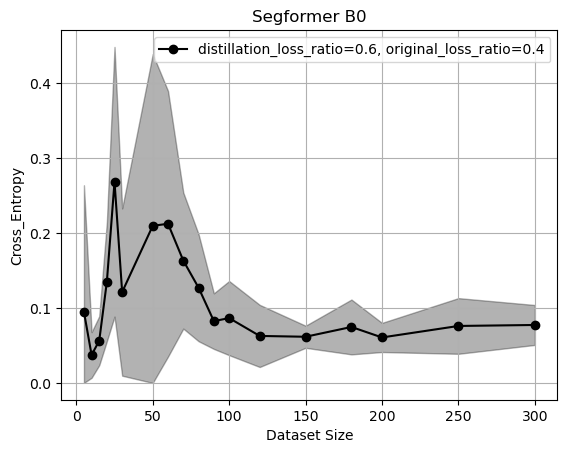

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()